In [1]:
## reference https://huggingface.co/learn/nlp-course/en/chapter7/6?fw=pt#training-a-causal-language-model-from-scratch

In [2]:
#installing some libraries
#!pip install datasets
!pip install --upgrade jupyter ipywidgets



Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch, transformers
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from transformers import PreTrainedModel, PretrainedConfig
from transformers import AutoModel, AutoConfig,AutoModelForCausalLM, GPT2Config,GPT2Tokenizer,GPT2LMHeadModel
from transformers import BertModel, BertTokenizer, GPT2LMHeadModel,BertConfig,DistilBertModel, DistilBertTokenizer,DistilBertConfig
import torch.nn as nn
import torch.nn.functional as F
#from datasets import load_dataset
import pandas as pd, numpy as np
from torch.cuda.amp import autocast
from torch import cuda
import datetime
import warnings,itertools
from torch.optim.lr_scheduler import LambdaLR
import json
import random
# Ignore all warnings
warnings.filterwarnings('ignore')
#pip install transformers bitsandbytes>=0.39.0 -q
import zipfile,logging

In [4]:
#global params for training

B =  32
T_g = 1024
T_b = 512
epoch = 100
random_init_wts = True
# hard coded compression ratio. This is the ratio of text_len to the # of tokens produced by the tokeinzer
comp_ratio = 3

if cuda.is_available():
    device = torch.device('cuda:0')
    print(device)
else:
    device = 'cpu'
#print(device)
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"
#os.environ["MKL_DEBUG_CPU_TYPE"] = "5"

#print(global_tr_loss)
model_path = os.path.join("model")
print(model_path)

cuda:0
model


In [5]:
directory = os.path.join('.','data','unzip_text_10M')  # Replace with your directory path
directory

'./data/unzip_text_10M'

In [6]:
def read_text(directory):
    directory = os.path.join('.','data','unzip_text_10M',str(directory))  # Replace with your directory path
    print(f"directory :{directory}")
    # List all files in the directory
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    print(f"files:{files}")
    text_content = []
    # Read each file
    total_lines = 0
    for filenum,filename in enumerate(files):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            #first_line = file.read()
            #print(f"filename :{filename}->first few lines {first_line}")
            #continue
            #lines_list = [line.strip() for line in open(file_path, 'r')]
            text = file.read()
            text_content.append(text)
            print(f"the file:{filename} has been appeneded to the uber list and its length is {len(text_content)} ")
            #total_lines+=len(lines_list)
            #text_content.append(lines_list)
    
    flattened_list = ''.join(text_content)
    assert (len(flattened_list) == total_lines , f"Expected {len(flattened_list)} to be equal to {total_lines}" )
    
    return flattened_list

    

In [7]:
train_list = read_text("train_10M")


directory :./data/unzip_text_10M/train_10M
files:['switchboard.train', 'simple_wiki.train', 'open_subtitles.train', 'gutenberg.train', 'childes.train', 'bnc_spoken.train']
the file:switchboard.train has been appeneded to the uber list and its length is 1 
the file:simple_wiki.train has been appeneded to the uber list and its length is 2 
the file:open_subtitles.train has been appeneded to the uber list and its length is 3 
the file:gutenberg.train has been appeneded to the uber list and its length is 4 
the file:childes.train has been appeneded to the uber list and its length is 5 
the file:bnc_spoken.train has been appeneded to the uber list and its length is 6 


In [8]:
len(train_list)

54215049

In [9]:
val_list = read_text("dev")


directory :./data/unzip_text_10M/dev
files:['switchboard.dev', 'simple_wiki.dev', 'open_subtitles.dev', 'gutenberg.dev', 'childes.dev', 'bnc_spoken.dev']
the file:switchboard.dev has been appeneded to the uber list and its length is 1 
the file:simple_wiki.dev has been appeneded to the uber list and its length is 2 
the file:open_subtitles.dev has been appeneded to the uber list and its length is 3 
the file:gutenberg.dev has been appeneded to the uber list and its length is 4 
the file:childes.dev has been appeneded to the uber list and its length is 5 
the file:bnc_spoken.dev has been appeneded to the uber list and its length is 6 


In [10]:
# # Test the tokenizer:
bert_model_name = 'distilbert-base-uncased'
gpt2_model_name = 'distilgpt2'
bert_tokenizer = DistilBertTokenizer.from_pretrained(bert_model_name)
bert_config =  DistilBertConfig()
bert_model = DistilBertModel(bert_config)
gpt2_config = AutoConfig.from_pretrained(gpt2_model_name, vocab_size = 50304)
gpt_model = AutoModelForCausalLM.from_config(gpt2_config)


In [11]:
gpt_tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")
if gpt_tokenizer.pad_token is None:
    gpt_tokenizer.add_special_tokens({'pad_token': '[PAD]'})
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name)
if bert_tokenizer.pad_token is None:
    bert_tokenizer.add_special_tokens({'pad_token': '[PAD]'})

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [12]:
# class BertGPT2EncoderDecoder_bkp(torch.nn.Module):
#     def __init__(self, bert_model, gpt_model):
#         super(BertGPT2EncoderDecoder, self).__init__()
#         self.bert_model = bert_model
#         self.gpt_model = gpt_model
        
#         # Linear layer to match BERT output dim to GPT-2 input dim
#         self.linear = torch.nn.Linear(bert_model.config.hidden_size, gpt_model.config.n_embd)

#     def forward(self, bet_enc,gpt_enc, labels=None):
#         # Encode with BERT
#         bert_input_id = bet_enc['input_ids']
#         bert_attention = bet_enc['attention_mask']
        
#         gpt_input_id = gpt_enc['input_ids']
#         gpt_attention = gpt_enc['attention_mask']
        
#         bert_input_id = bert_input_id.view(B,T_b)
#         bert_attention = bert_attention.view(B,T_b)
        
#         print(f"shape that goes into the model | input_id = {bert_input_id.shape}|attention_mask = {bert_attention.shape}")
        
#         encoder_outputs = self.bert_model(input_ids=bert_input_id, attention_mask=bert_attention)
#         encoder_hidden_states = encoder_outputs.last_hidden_state  # Shape: [batch_size, seq_len, bert_hidden_size]
#         print(f"shape of Bert output = {encoder_hidden_states.shape}")
                
#         # Project BERT output to GPT-2 input dimension
#         projected_encoder_hidden_states = self.linear(encoder_hidden_states)  # Shape: [batch_size, seq_len, gpt2_hidden_size]
#         print(f"After linear layer shape = {projected_encoder_hidden_states.shape}")
#         # Decode with GPT-2
#         extended_hidden_states = torch.cat([projected_encoder_hidden_states] * 2, dim=1)  # Shape: [batch_size, 1024, gpt2_hidden_size]
#         # Extend attention mask
#         extended_attention_mask = torch.cat([bert_attention] * 2, dim=1)  # Shape: [batch_size, 1024]
#         print(f"shape of extended_hidden_sate = {extended_hidden_states.shape}| extended attenion shape = {extended_attention_mask.shape}")
#         labels = torch.cat([bert_input_id] * 2, dim=1).view(B,T_g)
        
        
#         decoder_outputs = self.gpt_model(inputs_embeds=extended_hidden_states, attention_mask = extended_attention_mask,
#                                           labels=labels)
#         #print(f"decoder_outputs = {decoder_outputs}")

        

#         return decoder_outputs

In [13]:
def tokenize_text (text,bert_tokenizer = bert_tokenizer,bert_max_length = B*T_b):
    #print(f"inside tokenize_text")
    enc_bert = bert_tokenizer(text,padding='max_length',truncation=True,max_length=bert_max_length,return_tensors="pt",return_attention_mask=True)
    #enc_gpt = gpt_tokenizer(text,padding='max_length',truncation=True,max_length=gpt_max_len,return_tensors="pt",return_attention_mask=True)
    
    return enc_bert
    
    
    
        
    


### Data loaders and Dataset for batched training

In [14]:
class dataset_pyt_train(Dataset):
    def __init__(self, text_list, B = B, bert_tokenizer = bert_tokenizer, T_b = T_b,comp_ratio = comp_ratio):
        self.text_list = text_list
        #print(f"Value of B {B}")
        self.bert_tokeinzer = bert_tokenizer     
        
                                        
    def __getitem__(self, idx):
        
        chunk = self.text_list[idx:idx + B*T_b*comp_ratio]
        enc_bert = tokenize_text(chunk)
                
        return enc_bert
        
        
    def __len__(self):
        
        num_chunks = comp_ratio*B*T_b
        return len(self.text_list)//num_chunks

In [15]:
class dataset_pyt_val(Dataset):
    def __init__(self, text_list, B = B, bert_tokenizer = bert_tokenizer, T_b = T_b,comp_ratio = comp_ratio):
        self.text_list = text_list
        #print(f"Value of B {B}")
        self.bert_tokeinzer = bert_tokenizer     
        
                                        
    def __getitem__(self, idx):
        
        chunk = self.text_list[idx:idx + B*T_b*comp_ratio]
        enc_bert = tokenize_text(chunk)
                
        return enc_bert
        
        
    def __len__(self):
        
        num_chunks = comp_ratio*B*T_b
        return len(self.text_list)//num_chunks

In [16]:


class BertGPT2EncoderDecoder(PreTrainedModel):
    def __init__(self, bert_model, gpt_model):
        config = bert_model.config
        super().__init__(config)
        self.bert_model = bert_model
        self.gpt_model = gpt_model
        
        # Linear layer to match BERT output dim to GPT-2 input dim
        self.linear = torch.nn.Linear(bert_model.config.hidden_size, gpt_model.config.n_embd)

    def forward(self, input_ids,attention_mask, labels):
        # Encode with BERT
#         bert_input_id = bet_enc['input_ids']
#         bert_attention = bet_enc['attention_mask']
        
        bert_input_id = input_ids.view(B, T_b)
        bert_attention = attention_mask.view(B, T_b)
        
        #print(f"shape that goes into the model | input_id = {bert_input_id.shape} | attention_mask = {bert_attention.shape}")
        
        encoder_outputs = self.bert_model(input_ids=bert_input_id, attention_mask=bert_attention)
        encoder_hidden_states = encoder_outputs.last_hidden_state  # Shape: [batch_size, seq_len, bert_hidden_size]
        #print(f"shape of Bert output = {encoder_hidden_states.shape}")
                
        # Project BERT output to GPT-2 input dimension
        projected_encoder_hidden_states = self.linear(encoder_hidden_states)  # Shape: [batch_size, seq_len, gpt2_hidden_size]
        #print(f"After linear layer shape = {projected_encoder_hidden_states.shape}")
        
        # Decode with GPT-2
        extended_hidden_states = torch.cat([projected_encoder_hidden_states] * 2, dim=1)  # Shape: [batch_size, 1024, gpt2_hidden_size]
        extended_attention_mask = torch.cat([bert_attention] * 2, dim=1)  # Shape: [batch_size, 1024]
        #print(f"shape of extended_hidden_sate = {extended_hidden_states.shape} | extended attenion shape = {extended_attention_mask.shape}")
        
        labels = torch.cat([bert_input_id] * 2, dim=1).view(B, T_g)
        
        decoder_outputs = self.gpt_model(inputs_embeds=extended_hidden_states, attention_mask=extended_attention_mask, labels=labels)
        
        return decoder_outputs

In [17]:
#train_dataset = dataset_pyt(filtered_df,tokenizer = tokenizer)
train_dataset = dataset_pyt_train(train_list)
val_dataset = dataset_pyt_val(val_list)

train_loader = DataLoader(train_dataset,batch_size = 1, shuffle = True , num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_dataset,batch_size = 1, shuffle = True , num_workers = 4, pin_memory = True)


In [18]:
model = BertGPT2EncoderDecoder(bert_model = bert_model, gpt_model = gpt_model)
model.to(device)
model = torch.compile(model)

In [19]:
# for i in range(0,len(train_dataset)):
#     enc_bert = train_dataset[i]
#     ids = enc_bert['input_ids']
#     att_mask = enc_bert['attention_mask']
#     ids = ids.to(device=device, non_blocking=True)
#     ids = torch.squeeze(ids, dim = 0)
#     att_mask = att_mask.to(device=device, non_blocking=True)
#     att_mask =  torch.squeeze(att_mask, dim = 0)
#     labels = ids.clone().to(device)
#     with autocast(dtype = torch.bfloat16):
#         model_output = model(input_ids = ids ,attention_mask = att_mask, labels = labels)
#     print(f"i = {i}|loss = {model_output.loss}")

In [20]:
def write_file(log_message, model_name = "enc_dec" ,random_init_wts = random_init_wts ):
    current_datetime = datetime.datetime.now()
    # Extract date and time components
    current_date = str(current_datetime.date())
    log_file = model_name +'_COS_SIM_'+'random_init_wts'+ '_'+str(random_init_wts)+'_' +current_date+'.log'
    print(f"*****LOGGING INFO IN {log_file}*********")
    filepath = os.path.join("model",log_file)
    logging.basicConfig(filename=filepath, 
                    filemode='a',  # Overwrite the log file each time
                    format='%(asctime)s - %(levelname)s - %(message)s', 
                    level=logging.DEBUG)
    logger = logging.getLogger()
    logger.info(log_message)
    
    

    
    

In [21]:
print(f"Length of the train loader is {len(train_loader)}")
print(f"Length of the val loader is {len(val_loader)}")
print(f"num_tokens= {B*T_g*len(train_loader)}")

Length of the train loader is 1103
Length of the val loader is 1150
num_tokens= 36143104


In [22]:
#emb,att,inp = train_dataset[1]

In [23]:
class check_train_metrics:
    def __init__(self, patience=20, min_delta=0 , B = B, T = T_g,best_loss = torch.inf,early_stop = False):
        self.patience = patience
        self.min_delta = min_delta
        self.train_counter = 0
        self.best_loss = best_loss
        self.early_stop = early_stop
        self.improvement = None

    def __call__(self, loss, epoch , epoch_durn, norm , current_lr, num_token):
        if self.best_loss - loss > self.min_delta:
            
            print(f"training loss has decreased---> reducing the best loss from {self.best_loss:.2f} to {loss:.2f} | throughput = {int(num_token/epoch_durn)} tokens/second | norm = {norm:.4f} | learning rate = {current_lr:.5e}")
            self.best_loss = loss
            self.train_counter = 0
            self.improvement = True
        else:
            self.train_counter += 1
            self.improvement = False
            print(f"No improvement in training  loss-->epoch= {epoch} and best loss is {self.best_loss:.2f}|current_loss = {loss}|counter = {self.train_counter}")
            if self.train_counter >= self.patience:
                self.early_stop = True


In [24]:
class check_val_metrics:
    def __init__(self, patience=10, min_delta=0, best_loss = torch.inf,early_stop = False):
        self.patience = patience
        self.min_delta = min_delta
        self.val_counter = 0
        self.best_loss = best_loss
        self.early_stop = early_stop
        

    def __call__(self, loss, epoch , model, bert_tokenizer):
        if self.best_loss - loss > self.min_delta:
            print(f"Val loss has decreased -->reducing the global validation loss from {self.best_loss:.2f} to {loss:.2f}")
            s1 = (f"Val loss has decreased -->reducing the global validation loss from {self.best_loss:.2f} to {loss:.2f}")
            print(f" validation loss for epoch = {epoch} is {loss:.4f}")
            self.best_loss = loss
            s2 = f" validation loss for epoch = {epoch} is {loss:.4f}"
            print(f" epoch= {epoch} :  val loss is {loss:.4f} ")
            s3 = f" epoch= {epoch} :  val loss is {loss:.4f} "
            #save the model
            # Get the current date and time
            current_datetime = datetime.datetime.now()
            # Extract date and time components
            current_date = str(current_datetime.date())
            current_time = str(current_datetime.time()).split('.')[0]
            file_name = 'model'+ current_date+current_time+'.pth'
            path = os.path.join("model",file_name)
            print(f"saving the model {file_name}")
            s4 = f"saving the model {file_name}"
            #torch.save(model.state_dict(), path)
            model.save_pretrained(path)
            bert_tokenizer.save_pretrained(path)
            log_message = s1+s2+s3+s4
            write_file(log_message)
            self.val_counter = 0
        else:
            self.val_counter += 1
            print(f"No improvement in validation loss-->epoch= {epoch} and best val loss is {self.best_loss:.2f}|current_Val loss = {loss}|val_counter = {self.val_counter}")
            if self.val_counter >= self.patience:
                self.early_stop = True

In [25]:
#model_output = model(input_ids = inp ,attention_mask = att, labels = inp)

In [26]:
@torch.no_grad

def eval_model(val_loader, model, epoch , device = device,tokenizer = bert_tokenizer):
    model.eval()
    model.to(device)
    e = epoch+1
    val_loss_accum = 0.0
    
    print(f"inside validation data for epoch {e}")
    for ind,(enc_bert) in enumerate(val_loader):
        ids = enc_bert['input_ids']
        att_mask = enc_bert['attention_mask']
        ids = ids.to(device=device, non_blocking=True)
        ids = torch.squeeze(ids, dim = 0)
        att_mask = att_mask.to(device=device, non_blocking=True)
        att_mask =  torch.squeeze(att_mask, dim = 0)
        labels = ids.clone().to(device)
        with autocast(dtype = torch.bfloat16):
            model_output = model(input_ids = ids ,attention_mask = att_mask, labels = labels)
            total_loss = model_output.loss
            
    
    
        val_loss_accum+= total_loss.detach().item()
        del att_mask,labels,model_output,total_loss,ids
    return val_loss_accum        
    
    
    


In [27]:

def train_model(train_loader,val_loader,model,num_epoch = 100,device = device,tokenizer = bert_tokenizer):
    #model.train()
    device = device
    lr_custom = 1e-5
    print(f"inside train model. Device = {device}")
    model.to(device)
    optimizer = torch.optim.AdamW(params =  model.parameters(), lr= lr_custom,fused = True ,weight_decay = .1)
      
    extra_train = .1*num_epoch
    max_train_steps = int(num_epoch +extra_train )
    import time
    from transformers import get_linear_schedule_with_warmup
    total_steps = len(train_loader) * num_epoch
    scheduler_cos = transformers.get_cosine_schedule_with_warmup( optimizer= optimizer, num_warmup_steps =int(total_steps * 0.1) ,num_training_steps= total_steps )
        
    epoch_train_log = []
    epoch_val_log = []
    validate_val_metric = check_val_metrics()
    validate_train_metric = check_train_metrics()
    for i in range (max_train_steps):
        
        epoch_start_time = time.time()
        optimizer.zero_grad(set_to_none=True)
        # we use 2 schedulers - the first LR scheduler uses a cosine decay for 100 epochs the second scheduler takes the last LR from cosine scheduler and then maintains that LR for the next 10 epochs
        if i >= num_epoch:
            optimizer_reduced_lr = torch.optim.AdamW(params =  model.parameters(), lr= current_lr ,fused = True , weight_decay=.1)
            scheduler_constant = transformers.get_constant_schedule_with_warmup( optimizer = optimizer_reduced_lr ,num_warmup_steps = 0, last_epoch = -1 )
        
        epoch_train_loss = 0       
        for ind,(enc_bert) in enumerate(train_loader):
            if ind == int(len(train_loader)/2):
                batch_time = time.time()
                duration = batch_time - epoch_start_time
                print(f"executing epoch:{i+1}, it took {duration/60} mins from beginning of epoch till batch#{ind}")
            
            ids = enc_bert['input_ids']
            att_mask = enc_bert['attention_mask']
            ids = ids.to(device=device, non_blocking=True)
            ids = torch.squeeze(ids, dim = 0)
            att_mask = att_mask.to(device=device, non_blocking=True)
            att_mask =  torch.squeeze(att_mask, dim = 0)
            labels = ids.clone().to(device)
            with autocast(dtype = torch.bfloat16):
                model_output = model(input_ids = ids ,attention_mask = att_mask, labels = labels)
                total_loss = model_output.loss
            
                    
            total_loss.backward()
            epoch_train_loss += total_loss.detach().item()
            norm = torch.nn.utils.clip_grad_norm(model.parameters() , 1.0)
            if i <= num_epoch:
                optimizer.step()
                scheduler_cos.step()
                optimizer.zero_grad(set_to_none=True)
            else:
                optimizer_reduced_lr.step()
                optimizer_reduced_lr.zero_grad(set_to_none=True)
                scheduler_constant.step()
                
                         
            del att_mask,labels,model_output,ids
            
        #batch processing complete 
        #print(f"batch processing complete , lambda = {lambda_val} |total_loss for batch= {total_loss}")
        
        if i <= num_epoch:
            current_lr = scheduler_cos.get_last_lr()[0]
        epoch_end_time = time.time()
        epoch_durn = (epoch_end_time - epoch_start_time)
        num_token = B*T_g*len(train_loader)
        epoch_train_log.append(epoch_train_loss)
        validate_train_metric(epoch_train_loss, i , epoch_durn, norm , current_lr, num_token)
        
        if validate_train_metric.improvement:
            val_loss= eval_model(val_loader, model, epoch = i, device = device,tokenizer = bert_tokenizer)
            epoch_val_log.append(val_loss)
            validate_val_metric(val_loss, i , model, bert_tokenizer)
            if validate_train_metric.early_stop or validate_val_metric.early_stop :
                print(f"early stopping trigerred either from training data or val data | train_counter = {validate_train_metric.train_counter}|val_counter = {validate_val_metric.val_counter}")
                break
        else:
            if validate_val_metric.early_stop:
                print(f"early stopping trigerred from validation data")
                break
              
    
    return model,epoch_train_log,epoch_val_log
        
            
            
    
    

In [28]:
tr_model,epoch_train_log,epoch_val_log = train_model(train_loader, val_loader,model=model,tokenizer = bert_tokenizer)

inside train model. Device = cuda:0
executing epoch:1, it took 2.673064657052358 mins from beginning of epoch till batch#551
training loss has decreased---> reducing the best loss from inf to 9111.40 | throughput = 123509 tokens/second | norm = 2.1404 | learning rate = 1.00000e-06
inside validation data for epoch 1
Val loss has decreased -->reducing the global validation loss from inf to 6594.82
 validation loss for epoch = 0 is 6594.8203
 epoch= 0 :  val loss is 6594.8203 
saving the model model2024-07-2721:01:07.pth
*****LOGGING INFO IN enc_dec_COS_SIM_random_init_wts_True_2024-07-27.log*********
executing epoch:2, it took 2.5878453811009723 mins from beginning of epoch till batch#551
training loss has decreased---> reducing the best loss from 9111.40 to 5062.02 | throughput = 128865 tokens/second | norm = 6.8435 | learning rate = 2.00000e-06
inside validation data for epoch 2
Val loss has decreased -->reducing the global validation loss from 6594.82 to 5553.40
 validation loss for e

In [29]:
# import json , os
# path_var_train_log = os.path.join(".","Tokenizers_and_loss_vals","epoch_train_plain_loss.json")
# path_var_val_log = os.path.join(".","Tokenizers_and_loss_vals","epoch_val_val_loss_.json")

# #print(path_var)
# #Write the list to a JSON file
# with open(path_var_train_log, "w") as file:
#     json.dump(epoch_train_log, file)

# with open(path_var_val_log, "w") as file:
#     json.dump(epoch_val_log, file)


In [30]:
# with open(path_var_train_log, "r") as file:
#     train_loss = json.load(file)
# with open(path_var_val_log, "r") as file:
#     val_loss = json.load(file)

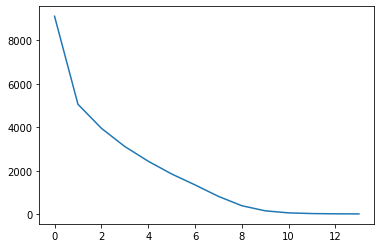

In [31]:
x_values = range(len(epoch_train_log))
plt.plot(x_values, epoch_train_log, label='Train_loss')

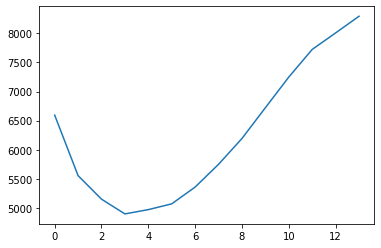

In [32]:
#epoch_val_log= [t.detach().cpu().numpy() for t in epoch_val_log]
x_values_val = range(len(epoch_val_log))
plt.plot(x_values_val, epoch_val_log, label='val_loss')

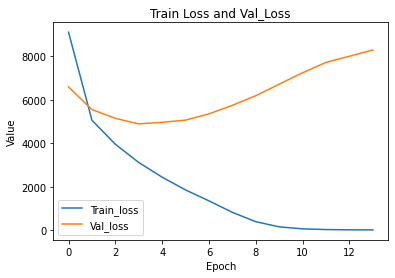

In [33]:
min_length = min(len(epoch_train_log), len(epoch_val_log))
list1 = epoch_train_log[:min_length]
list2 = epoch_val_log[:min_length]

# Create x-axis values
x_values = range(min_length)

# Plot the lists
plt.plot(x_values, list1, label='Train_loss')
plt.plot(x_values, list2, label='Val_loss')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Train Loss and Val_Loss')
plt.legend()